In [4]:
import pickle
from string import punctuation

import pandas as pd
from sklearn.model_selection import train_test_split

In [5]:
import numpy as np
import json
import dask.bag as db

In [3]:
# Load the data
import logging
logger = logging.getLogger("spacy")
logger.setLevel(logging.ERROR)

import dask.bag as db
import json

docs = db.read_text('../Data/arxiv-metadata-oai-snapshot.json').map(json.loads)

In [ ]:
# Trimming the data
get_latest_version = lambda x: x['versions'][-1]['created']


# get only necessary fields of the metadata file
trim = lambda x: {'id': x['id'],
                  'versions': x['versions'],
                  'category':x['categories'].split(' '),
                  'abstract':x['abstract'],}

# filter for papers published before 2022
columns = ['id','category','abstract','versions']
docs_df = (docs.filter(lambda x: int(get_latest_version(x).split(' ')[3]) <2022)
           .map(trim).
           compute())

# convert to pandas
docs_df = pd.DataFrame(docs_df)

In [ ]:
#save trimmed dataset for later use so we can skip the dataset trimming later:
docs_df.to_csv("../Data/trimmed_arxiv_docs3.csv", index=False)

In [6]:
# Read docs from the file
df = pd.read_csv('../Data/trimmed_arxiv_docs3.csv')

/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
categories = list(df['category'].unique())

In [8]:
# Split categories
def splitCategory(cat):
    tmp = cat.replace('[','').replace(']','')
    c = tmp.split(', ')
    c = [w.replace("'","") for w in c]
    return c

In [9]:
# Find main category
def findMainCat(categories):
    new_cat = list(dict.fromkeys([cat.split(".")[0] for cat in categories]))
    return new_cat

In [10]:
# Getting rid of duplicates
df.drop_duplicates(['abstract',], inplace=True)
df['abstract'].describe(include='all')

count                                               2038555
unique                                              2038555
top         A fully differential calculation in perturba...
freq                                                      1
Name: abstract, dtype: object

In [11]:
df.drop(labels=['id', 'authors', 'title'], axis =1)

,versions,category,abstract
0,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",['hep-ph'],A fully differential calculation in perturba...
1,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...","['math.CO', 'cs.CG']","We describe a new algorithm, the $(k,\ell)$-..."
2,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",['physics.gen-ph'],The evolution of Earth-Moon system is descri...
3,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",['math.CO'],We show that a determinant of Stirling cycle...
4,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...","['math.CA', 'math.FA']",In this paper we show how to compute the $\L...
...,...,...,...
2040230,"[{'version': 'v1', 'created': 'Mon, 26 Aug 199...","['supr-con', 'cond-mat.supr-con']",We report on measurements of the angular dep...
2040231,"[{'version': 'v1', 'created': 'Sat, 31 Aug 199...","['supr-con', 'cond-mat.supr-con']",The non-linear microwave surface impedance o...
2040232,"[{'version': 'v1', 'created': 'Tue, 3 Sep 1996...","['supr-con', 'cond-mat.supr-con']",The vortex contribution to the dc field (H) ...
2040233,"[{'version': 'v1', 'created': 'Wed, 18 Sep 199...","['supr-con', 'cond-mat.supr-con']",We show that the density of states in an ani...


NLP Processing

In [12]:
# Add the categories
df['list_categories'] = df.category.apply(splitCategory)
df['main_categories'] = df.list_categories.apply(findMainCat)

In [13]:
list(df['main_categories'])

[['hep-ph'],
 ['math', 'cs'],
 ['physics'],
 ['math'],
 ['math'],
 ['cond-mat'],
 ['gr-qc'],
 ['cond-mat'],
 ['astro-ph'],
 ['math'],
 ['math'],
 ['math'],
 ['math'],
 ['math'],
 ['hep-th'],
 ['hep-ph'],
 ['astro-ph'],
 ['hep-th'],
 ['math'],
 ['hep-ex'],
 ['nlin', 'physics', 'q-bio'],
 ['math'],
 ['astro-ph'],
 ['nlin'],
 ['cond-mat'],
 ['math'],
 ['cond-mat'],
 ['math'],
 ['hep-ph'],
 ['cond-mat'],
 ['hep-ph'],
 ['hep-ph'],
 ['physics'],
 ['q-bio', 'quant-ph'],
 ['physics'],
 ['q-bio'],
 ['physics'],
 ['physics'],
 ['hep-ph', 'hep-lat', 'nucl-th'],
 ['math'],
 ['math', 'math-ph'],
 ['physics', 'quant-ph'],
 ['cond-mat'],
 ['astro-ph', 'nlin', 'physics'],
 ['nlin'],
 ['quant-ph', 'cs', 'math'],
 ['cs'],
 ['gr-qc', 'astro-ph'],
 ['math'],
 ['cs'],
 ['physics', 'quant-ph'],
 ['hep-th'],
 ['math', 'gr-qc'],
 ['math'],
 ['cond-mat'],
 ['cond-mat'],
 ['cond-mat'],
 ['physics'],
 ['astro-ph'],
 ['nucl-th'],
 ['math'],
 ['cs'],
 ['hep-ph'],
 ['hep-th'],
 ['math'],
 ['hep-th'],
 ['cond-mat'],

In [14]:
# Create CS and Random dataframes
bool_series = ["cs" == cat[0] for cat in df.main_categories]
df_cs = df[bool_series]

In [15]:
df_cs['main_categories']

46                            [cs]
49                            [cs]
61                            [cs]
89         [cs, cond-mat, physics]
97                      [cs, math]
                    ...           
1793448                       [cs]
1793449                       [cs]
1793450                       [cs]
1793451                       [cs]
1793452                       [cs]
Name: main_categories, Length: 339778, dtype: object

In [16]:
# Non-CS df
bool_series = [cat[0] != "cs" for cat in df.main_categories]
df_random = df[bool_series]

In [17]:
def get_year(version):
    return int(version.split(': ')[2].split(' ')[3])

In [18]:
import datetime
def get_month(version):
    month_name = version.split(': ')[2].split(' ')[2]
    datetime_object = datetime.datetime.strptime(month_name, "%b")
    month_number = datetime_object.month
    return month_number

In [151]:
def get_quarter(version):
    year = get_year(version)
    month = get_month(version)
    date = int(year)*4+int(month/3)
    return date

In [ ]:
df_cs['year'] = df_cs.versions.apply(get_year)
df_random['year'] = df_random.versions.apply(get_year)
df_cs['quarter'] = df_cs.versions.apply(get_quarter)
df_random['quarter'] = df_random.versions.apply(get_quarter)

In [21]:
# Exclude 2022
bool_series = [year<2022 for year in df_cs.year]
df_cs = df_cs[bool_series]

In [22]:
# Exclude 2022
bool_series = [year<2022 for year in df_random.year]
df_random = df_random[bool_series]

In [23]:
for col in df_cs.columns:
    print(col)

id
authors
title
versions
category
abstract
list_categories
main_categories
year
quarter


In [24]:
df_cs.drop(labels=['id', 'authors', 'title'], axis =1)
df_random.drop(labels=['id', 'authors', 'title'], axis =1)


,versions,category,abstract,list_categories,main_categories,year,quarter
0,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",['hep-ph'],A fully differential calculation in perturba...,[hep-ph],[hep-ph],2007,24088
1,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...","['math.CO', 'cs.CG']","We describe a new algorithm, the $(k,\ell)$-...","[math.CO, cs.CG]","[math, cs]",2007,24087
2,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",['physics.gen-ph'],The evolution of Earth-Moon system is descri...,[physics.gen-ph],[physics],2007,24088
3,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",['math.CO'],We show that a determinant of Stirling cycle...,[math.CO],[math],2007,24087
4,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...","['math.CA', 'math.FA']",In this paper we show how to compute the $\L...,"[math.CA, math.FA]",[math],2007,24088
...,...,...,...,...,...,...,...
2040230,"[{'version': 'v1', 'created': 'Mon, 26 Aug 199...","['supr-con', 'cond-mat.supr-con']",We report on measurements of the angular dep...,"[supr-con, cond-mat.supr-con]","[supr-con, cond-mat]",1996,23960
2040231,"[{'version': 'v1', 'created': 'Sat, 31 Aug 199...","['supr-con', 'cond-mat.supr-con']",The non-linear microwave surface impedance o...,"[supr-con, cond-mat.supr-con]","[supr-con, cond-mat]",1996,23960
2040232,"[{'version': 'v1', 'created': 'Tue, 3 Sep 1996...","['supr-con', 'cond-mat.supr-con']",The vortex contribution to the dc field (H) ...,"[supr-con, cond-mat.supr-con]","[supr-con, cond-mat]",1996,23961
2040233,"[{'version': 'v1', 'created': 'Wed, 18 Sep 199...","['supr-con', 'cond-mat.supr-con']",We show that the density of states in an ani...,"[supr-con, cond-mat.supr-con]","[supr-con, cond-mat]",1996,23961


In [25]:
df_cs['list_categories']

46                                            [cs.NE, cs.AI]
49                                            [cs.NE, cs.AI]
61                                                   [cs.DS]
89         [cs.CE, cond-mat.stat-mech, cs.MS, cs.NA, phys...
97                                          [cs.IT, math.IT]
                                 ...                        
1793448                                              [cs.CL]
1793449                                              [cs.SE]
1793450                                              [cs.CR]
1793451                                              [cs.DS]
1793452                                       [cs.MS, cs.CE]
Name: list_categories, Length: 326284, dtype: object

Reducing the dataset

In [26]:
def findSubCat(cat):
    try:
        return cat[0].split(".")[1]
    except:
        print(cat)
        return 'none'

In [27]:
df_cs['sub_category'] = df_cs.list_categories.apply(findSubCat)
#df_random['sub_category'] = df_random.list_categories.apply(findSubCat)

In [28]:
from collections import Counter
csub = Counter(list(df_cs['sub_category']))

In [29]:
csub = csub.most_common()

In [30]:
csub

[('CV', 52288),
 ('LG', 45808),
 ('IT', 28730),
 ('CL', 24667),
 ('AI', 14123),
 ('CR', 13834),
 ('NI', 12279),
 ('DS', 11972),
 ('RO', 11544),
 ('DC', 9685),
 ('LO', 8188),
 ('SE', 8060),
 ('SI', 7578),
 ('CY', 6876),
 ('IR', 5931),
 ('HC', 5371),
 ('GT', 5253),
 ('SY', 5086),
 ('NE', 4657),
 ('DB', 4476),
 ('CC', 4185),
 ('DM', 3951),
 ('PL', 3716),
 ('CG', 3396),
 ('SD', 3117),
 ('DL', 2655),
 ('CE', 2522),
 ('FL', 2243),
 ('OH', 1902),
 ('AR', 1681),
 ('MA', 1632),
 ('MM', 1554),
 ('GR', 1537),
 ('ET', 1448),
 ('NA', 1082),
 ('SC', 1007),
 ('PF', 902),
 ('MS', 880),
 ('OS', 375),
 ('GL', 93)]

In [31]:
#Number of paper in cs
print(len(df_random.index))
print(len(df_cs.index))

1671863
326284


In [32]:
from collections import OrderedDict
csub = OrderedDict(csub)

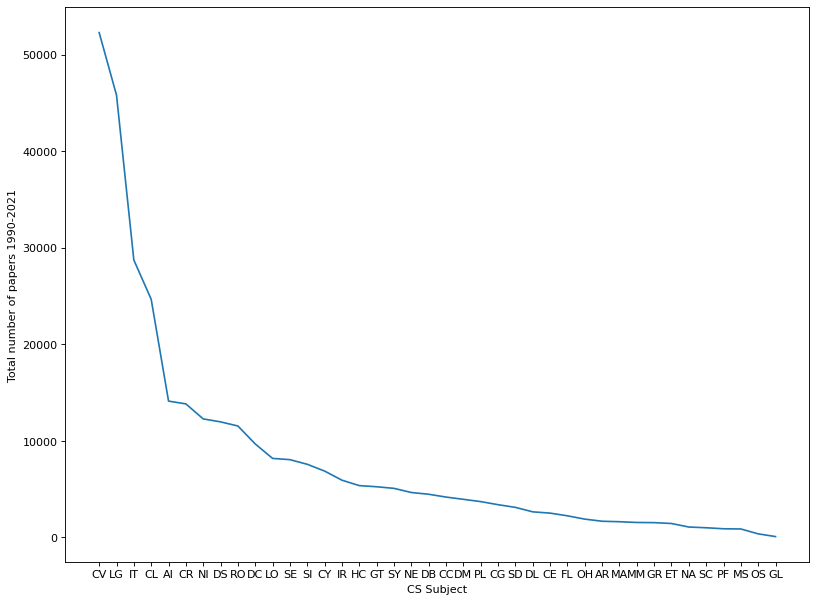

<Figure size 640x480 with 0 Axes>

In [185]:
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('default')
plt.figure(figsize=(12, 9), dpi=80)
x_plt = list(csub.keys())
y_plt = list(csub.values())
plt.plot(x_plt, y_plt)
plt.xlabel("CS Subject")
plt.ylabel("Total number of papers 1990-2021")
plt.show()
plt.savefig('../Graphs/Final/subjectDistributionFinal.png')

In [34]:
df_cs = df_cs.drop(columns=['id', 'authors', 'title'])

In [35]:
subcategories = list(set(list(df_cs['sub_category'])))

In [36]:
df_cs_reduced = pd.DataFrame(columns=list(df_cs.columns))
for subcat in subcategories:
    if(len(df_cs[df_cs['sub_category'] == subcat].index)>=2000):
        df_cs_reduced = df_cs_reduced.append(df_cs[df_cs['sub_category'] == subcat].sample(2000))
    else:
        df_cs_reduced = df_cs_reduced.append(df_cs[df_cs['sub_category'] == subcat])

In [37]:
df_cs_reduced = df_cs_reduced.drop(columns='versions')

In [38]:
# Reduce the size of the data
df_random = df_random.sample(len(df_cs_reduced.index), random_state=42)

In [39]:
df_cs_reduced.to_csv("../Data/df_cs_reduced.csv", index=False)
df_random.to_csv("../Data/df_random_reduced.csv", index=False)

In [40]:
df_cs = df_cs_reduced

NLP Processing

In [41]:
#Define stopwords (scientific stopwords)
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
stopwords = STOP_WORDS

In [42]:
#Define the cleaner - remove punctuation
def cleanPunct(text):
    return [w for w in text if w not in punctuation]

In [43]:
# make everything lowercase
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
def low(instance):
    tokens = word_tokenize(instance)
    return [w.lower() for w in tokens if w not in ["(", ")"]]
# Removing stopwords and punctuation
def clean(text):
    return [w for w in text if w not in punctuation and w not in stopwords and w.isalpha() and len(w)>1]
def low2(instance):
    tokens = word_tokenize(instance)
    return [w.lower() for w in tokens if w not in punctuation and w not in stopwords and w.isalpha() and len(w)>1]

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/miamijovic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [44]:
# Create column with lowercase text
df_cs_reduced['cleaned'] = df_cs.abstract.apply(low2)
df_random['cleaned'] = df_random.abstract.apply(low2)

In [45]:
# Make ngrams
from nltk.util import ngrams

def bigrams(arr):
    return list(ngrams(arr, 2))

def trigrams(arr):
    return list(ngrams(arr,3))

In [46]:
# Creating ngrams
df_cs['bigrams'] = df_cs.cleaned.apply(bigrams)
df_random['bigrams'] = df_random.cleaned.apply(bigrams)
df_cs['trigrams'] = df_cs.cleaned.apply(trigrams)
df_random['trigrams'] = df_random.cleaned.apply(trigrams)

In [47]:
def hyphenate(words, n):
    if(n==2):
        return [w[0]+'-'+w[1] for w in words]
    if(n==3):
        return [w[0]+'-'+w[1]+'-'+w[2] for w in words]

Language analysis

In [48]:
# Create dict func
def createDict(data):
    vocab = {}
    for instance in data:
        d = Counter(instance)
        for w in d.keys():
            if w in vocab:
                vocab[w] += d[w]
            else:
                vocab[w] = d[w]
    return dict(sorted(vocab.items(), key=lambda item: item[1], reverse=True))

In [49]:
from collections import Counter
uni_cs = createDict(df_cs['cleaned'])
bi_cs = createDict(df_cs['bigrams'])
tri_cs = createDict(df_cs['trigrams'])

uni_rand = createDict(df_random['cleaned'])
bi_rand = createDict(df_random['bigrams'])
tri_rand = createDict(df_random['trigrams'])

In [50]:
# Trim ngrams 
def trim(d, num):
    return dict((k, v) for k, v in d.items() if v>=num)

In [52]:
trim_value = 40
unigram_cs = trim(uni_cs, trim_value)
unigram_rand = trim(uni_rand, trim_value)
bigram_cs = trim(bi_cs, trim_value)
bigram_rand = trim(bi_rand, trim_value)
trigram_cs = trim(tri_cs, trim_value)
trigram_rand = trim(tri_rand, trim_value)

In [53]:
# Filter out dataframe, leave only ngrams from the list + hyphenate
def filterOutUniCs(words):
    return [w for w in words if w in unigram_cs]
def filterOutBiCs(words):
    return [w[0]+'-'+w[1] for w in words if w in bigram_cs]
def filterOutTriCs(words):
    return [w[0]+'-'+w[1]+'-'+w[2] for w in words if w in trigram_cs]
def filterOutUniRand(words):
    return [w for w in words if w in unigram_rand]
def filterOutBiRand(words):
    return [w[0]+'-'+w[1] for w in words if w in bigram_rand]
def filterOutTriRand(words):
    return [w[0]+'-'+w[1]+'-'+w[2] for w in words if w in trigram_rand]

In [54]:
df_cs.cleaned = df_cs.cleaned.apply(filterOutUniCs)
df_cs.bigrams = df_cs.bigrams.apply(filterOutBiCs)
df_cs.trigrams = df_cs.trigrams.apply(filterOutTriCs)

df_random.cleaned = df_random.cleaned.apply(filterOutUniRand)
df_random.bigrams = df_random.bigrams.apply(filterOutBiRand)
df_random.trigrams = df_random.trigrams.apply(filterOutTriRand)

Chi-Squared

In [55]:
#CHI-Square stastic where:
# a - number of times t and c co-occur 11
# b - number of times t occurs w/o c 10
# c - number of times c occurs w/o t 01
# d - number of times neither c nor t occur 00
def chi_square(n,a,b,c,d):
    return n*((a*d-c*b)**2)/((a+c)*(b+d)*(a+b)*(c+d))

In [56]:
def selectKbest(features, k):
    features = {a: v for a, v in sorted(features.items(), key=lambda item: item[1], reverse=True)}
    features = {a: features[a] for a in list(features)[:k]}
    return features

In [57]:
# a - number of times t and c co-occur 11 (term occurs in cs)
# b - number of times t occurs w/o c 10 (term occurs in random)
# c - number of times c occurs w/o t 01 (cs which dont contain term)
# d - number of times neither c nor t occur 00 (random which dont contain term)
def findChiValuesQuicker(cs_dict, random_dict, n):
    occurance_dict = {}
    chi_values = {}
    for instance in cs_dict['filteredAbstracts'].keys():
        terms = Counter(cs_dict['filteredAbstracts'][instance])
        for term in terms.keys():
            if(term in occurance_dict.keys()):
                if('a' in occurance_dict[term].keys()):
                    occurance_dict[term]['a'] += 1
                else:
                    occurance_dict[term]['a'] = 1
            else:
                occurance_dict[term] = {'a' : 1}
    for instance in random_dict['filteredAbstracts'].keys():
        terms = Counter(random_dict['filteredAbstracts'][instance])
        for term in terms.keys():
            if(term in occurance_dict.keys()):
                if('b' in occurance_dict[term].keys()):
                    occurance_dict[term]['b'] += 1
                else:
                    occurance_dict[term]['b'] = 1
            else:
                occurance_dict[term] = {'b' : 1}
    for term in occurance_dict.keys():
        if('a' in occurance_dict[term].keys()):
            occurance_dict[term]['c'] = int(n/2)-occurance_dict[term]['a']
        else:
            occurance_dict[term]['c'] = int(n/2)
            occurance_dict[term]['a'] = 0
        if('b' in occurance_dict[term].keys()):
            occurance_dict[term]['d'] = int(n/2)-occurance_dict[term]['b']
        else:
            occurance_dict[term]['d'] = int(n/2)
            occurance_dict[term]['b'] = 0
        chi_values[term] = chi_square(n, occurance_dict[term]['a'], occurance_dict[term]['b'], occurance_dict[term]['c'], occurance_dict[term]['d'])
    return chi_values

In [58]:
# Filter
def filterAbstract(tokens, chi_best_bi, chi_best_tri):
    # Find trigrams
    i = 0
    new1 = []
    while(i<len(tokens)-2):
        trigram = tokens[i]+'-'+tokens[i+1]+'-'+tokens[i+2]
        if(trigram in chi_best_tri):
            new1.append(trigram)
            i += 3
        else:
            new1.append(tokens[i])
            i += 1
    
    #Find bigrams
    i = 0
    new2 = []
    while(i<len(new1)-1):
        bigram = new1[i]+'-'+new1[i+1]
        if(bigram in chi_best_bi):
            new2.append(bigram)
            i += 2
        else:
            new2.append(new1[i])
            i += 1


    return new2

In [59]:
cs_dict = df_cs.to_dict()
random_dict = df_random.to_dict()

In [60]:
cs_dict['filteredAbstracts'] = {}
for instance in cs_dict['cleaned'].keys(): 
    cs_dict['filteredAbstracts'][instance] = filterAbstract(cs_dict['cleaned'][instance], cs_dict['bigrams'][instance], cs_dict['trigrams'][instance])

In [61]:
random_dict['filteredAbstracts'] = {}
for instance in random_dict['cleaned'].keys(): 
    random_dict['filteredAbstracts'][instance] = filterAbstract(random_dict['cleaned'][instance], random_dict['bigrams'][instance], random_dict['trigrams'][instance])

In [62]:
chi_values_quicker = findChiValuesQuicker(cs_dict, random_dict, len(df_cs.index)*2)

In [63]:
sorted_chi_values_quicker = {a: v for a, v in sorted(chi_values_quicker.items(), key=lambda item: item[1], reverse=True)}

In [64]:
sorted_chi_values_quicker

{'users': 3554.6144747357357,
 'algorithms': 3194.9387087081204,
 'algorithm': 3193.9360070265857,
 'user': 2913.6265891900066,
 'network': 2913.1135931734975,
 'task': 2820.0916498661995,
 'performance': 2613.541362596017,
 'design': 2607.8001217974975,
 'mass': 2509.038905486416,
 'tasks': 2401.5434917237367,
 'learning': 2241.876322758141,
 'observed': 2235.1696484694357,
 'language': 2170.77932343738,
 'architecture': 2017.4176630102065,
 'online': 1958.0076467715407,
 'in-paper-propose': 1936.4838245236529,
 'emission': 1888.1649436491264,
 'quantum': 1860.3838312033315,
 'networks': 1846.710158204733,
 'spin': 1843.6867570891106,
 'information': 1829.8906268438525,
 'spectra': 1814.3654049667182,
 'dataset': 1810.2909688025447,
 'stars': 1795.8089631631603,
 'training': 1792.1063731243075,
 'complexity': 1765.1580365923066,
 'communication': 1756.1178777360512,
 'software': 1721.2855989995603,
 'based': 1711.581782824106,
 'human': 1665.7361632491456,
 'research': 1653.0743125294

In [65]:
# Filter by chi value chiVal
def selectChiBest(features, chiVal):
    #features = {a: v for a, v in sorted(features.items(), key=lambda item: item[1], reverse=True)}
    features2 = {a: features[a] for a in features if features[a]>chiVal}
    return features2

In [66]:
chiVal = 90
chi_best = selectChiBest(sorted_chi_values_quicker, chiVal)
print(len(chi_best))

5413


In [67]:
df_cs.columns

Index(['category', 'abstract', 'list_categories', 'main_categories', 'year',
       'quarter', 'sub_category', 'cleaned', 'bigrams', 'trigrams'],
      dtype='object')

In [68]:
df_combined = df_cs[['abstract', 'list_categories', 'main_categories', 'year', 'quarter', 'sub_category']]

In [69]:
df_combined

,abstract,list_categories,main_categories,year,quarter,sub_category
1352,This paper reports on work aimed at supporti...,"[cs.OH, cs.DB, cs.DL, cs.HC]",[cs],2007,24088,OH
1837,The recently ratified IEEE 802.11e standard ...,[cs.OH],[cs],2007,24088,OH
1841,Most of the deployed IEEE 802.11e Wireless L...,[cs.OH],[cs],2007,24088,OH
2281,The configurations of single and double bond...,"[cs.OH, cs.DM]",[cs],2007,24088,OH
6353,This paper details the use of the IT Infrast...,[cs.OH],[cs],2007,24089,OH
...,...,...,...,...,...,...
477048,"For MIMO Rayleigh channels, it has been show...","[cs.IT, math.IT]","[cs, math]",2013,24167,IT
376200,Rare events can potentially occur in many ap...,"[cs.IT, math.IT]","[cs, math]",2012,24154,IT
97683,"In this paper, communication over imperfectl...","[cs.IT, math.IT]","[cs, math]",2008,24108,IT
853739,We propose an energy-efficient procedure for...,"[cs.IT, math.IT]","[cs, math]",2017,24209,IT


In [70]:
def filterAbstract(cs_dict, chi_best):
    completeDict = dict(chi_best)
    for key in cs_dict['filteredAbstracts'].keys():
        for term in cs_dict['filteredAbstracts'][key]:
            if term not in chi_best:
                cs_dict['filteredAbstracts'][key].remove(term)
                if(term in completeDict.keys()):
                    del completeDict[term]
    for val in cs_dict['filteredAbstracts'].values():    
        for key in val:
            if(key not in chi_best):
                print(key)
    return cs_dict, completeDict

In [96]:
cs_dict_filtered, completeDict = filterAbstract(cs_dict, chi_best)

In [97]:
for val in cs_dict_filtered['filteredAbstracts'].values():    
    for key in val:
        if(key not in chi_best):
            print(key)

In [98]:
# How big is the corpus
corpus_len = 0
for key in cs_dict_filtered['filteredAbstracts']:
    for abstract in cs_dict_filtered['filteredAbstracts'][key]:
        corpus_len += len(abstract)
print(corpus_len)

21956192


In [99]:
# Join in a form for glove training
abstr = [" ".join(abstract) for abstract in list(cs_dict_filtered['filteredAbstracts'].values())]
abstracts = "\n".join(abstr)

In [100]:
import itertools
with open('../glove/new_abstracts.txt', 'w') as f:
    f.write(abstracts)

GloVe Embeddings

In [101]:
import numpy as np
vectors_path = '../glove/vectors.txt' # Change this to the relative path on your machine

def load_glove_model(File):
    glove_model = {}
    with open(File,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

vectors = load_glove_model(vectors_path)
print(vectors['paper'])

4018 words loaded!
[-0.415383  0.110153 -0.712352  0.347235  0.580388 -0.17341  -0.494364
  0.118072 -0.236582  0.193043  0.00119   0.259983  0.663134 -0.046877
  0.650229  0.418498  0.291166  0.064998 -0.048369  0.388692  0.090702
  0.287972  0.259882  0.249338  0.180504 -0.025443  0.377239 -0.916481
  0.186581 -0.562469  0.637714  0.095186  0.392747  0.744091  0.524282
 -0.364367  0.528556  0.361685  0.070176 -0.075902 -0.135389  0.195517
 -0.84084  -0.349037  0.738676  0.327721  0.398952  0.701256 -0.487792
  0.684946]


In [102]:
def createVectors(all_terms, vectors):
    termDict = {}
    for term in all_terms:
        try:
            termDict[term] = vectors[term]
        except:
            print(term)
    return termDict

In [103]:
def vec2term(vector, vectors):
    for vec in vectors:
        if vec.value().all == vector:
            return vec.key()
    return "NO MATCH"

In [104]:
termDict = createVectors(completeDict, vectors)

galaxies
masses
galaxy
stellar
electrons
relativistic
photon
cosmological
gravitational
vacuum
ground-state
qcd
spectroscopy
galactic
chiral
luminosity
photons
black-hole
dark-matter
orbital
gev
telescope
quark
observables
neutrino
bright
jet
excitations
dust
redshift
fermions
dirac
black-holes
star-formation
nuclei
transverse
spectroscopic
mev
lhc
resonances
graphene
cosmic
we-calculate
perturbative
proton
supersymmetric
ions
magnetic-fields
accretion
photometry
astrophysical
neutrinos
hadronic
superconductivity
tev
suppressed
kev
jets
phenomenological
phase-diagram
magnetization
fermion
halo
higgs
neutron
cosmology
ion
scalar-field
electric-field
antiferromagnetic
metallicity
angular-momentum
hydrogen
excited
metallic
spins
inflation
quarks
general-relativity
cross-section
wavelengths
condensate
photometric
ionization
correlation-functions
cross-sections
radiative
fermi
fluxes
integrable
boson
observatory
abundances
meson
cohomology
planets
nucleon
shock
massless
bosons
here-report
b

In [80]:
with open('../Data/termDict2.json', 'w') as outfile:
    json.dump(str(termDict), outfile)   

Clustering

In [105]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
from sklearn import metrics

In [106]:
k = 200
kmeans = KMeans(n_clusters=k, random_state=42)
np_vectors= list(termDict.values())

In [107]:
import math
for i in range(len(np_vectors)):
    if(np.isnan(np.sum(np_vectors[i]))):
        np_vectors[i] = [0]*50

In [108]:
#PCA reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=20)

pca.fit(np_vectors)

PCA(n_components=20)

In [109]:
def kMeansPredict(np_vector):
    return kmeans.fit_predict(np_vector)

y_pred= kMeansPredict(np_vectors)

In [110]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000, random_state=0)
tsne_results = tsne.fit_transform(np_vectors)

/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


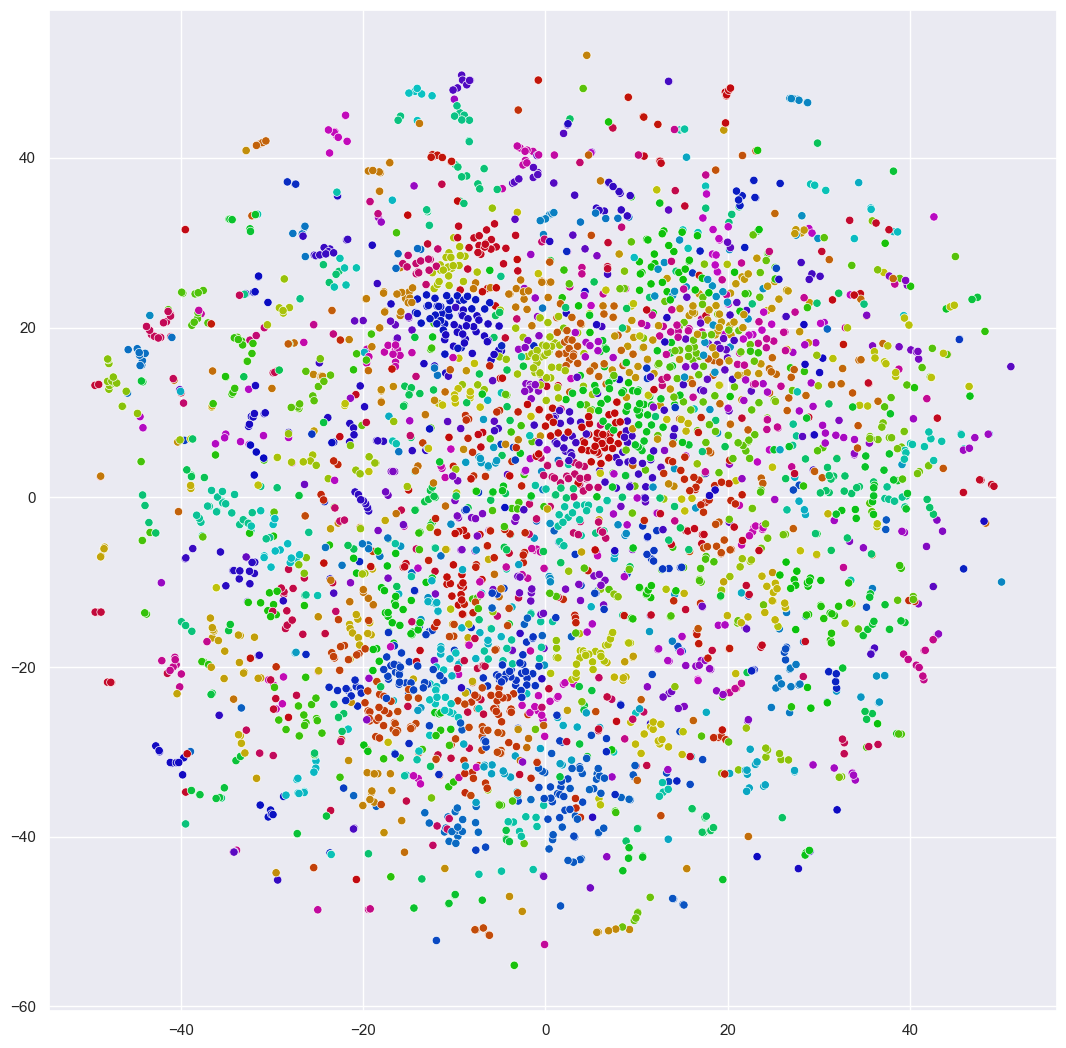

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(13,13)})

palette = sns.hls_palette(k, l=.4, s=.9)

sns.scatterplot(tsne_results[:,0], tsne_results[:,1], hue=y_pred, palette=palette, legend=False)
plt.savefig('../Graphs/scatterPlotTopics.png')

In [112]:
zip_iterator = zip(termDict.keys(), y_pred)

value_clusters = dict(zip_iterator)

In [113]:
clusters = {}
for term in value_clusters.items():
    clusters[term[1]] = []
for term in value_clusters.items():
    clusters[term[1]].append(term[0])

In [114]:
for i in clusters.keys():
    print(i,clusters[i])

59 ['users', 'user', 'human', 'people', 'social', 'environment', 'humans', 'trust', 'cognitive', 'perception', 'behavioral', 'interacting', 'feedback', 'interactions', 'interaction', 'behaviors']
9 ['algorithms', 'existing', 'techniques', 'approaches', 'approach', 'work', 'methods', 'proposed', 'algorithmic', 'practical', 'technique', 'context', 'computational', 'works', 'paper', 'method', 'first', 'in-paper', 'described', 'literature', 'additionally', 'view', 'step', 'here', 'moreover', 'using', 'furthermore', 'finally', 'applied', 'discussed', 'alternative', 'basic', 'criteria', 'employed', 'earlier', 'combining', 'standard', 'ideas', 'new', 'previous-work', 'procedures']
45 ['algorithm', 'running-time', 'polynomial-time', 'our-algorithm', 'computes', 'time-complexity', 'linear-time', 'we-present-algorithm', 'approximation-algorithm', 'the-algorithm', 'approximation-algorithms', 'runs', 'polynomial-time-algorithm', 'randomized-algorithm', 'time-algorithm', 'deterministic-algorithm', 

In [116]:
df_combined['filteredAbstracts'] = cs_dict_filtered['filteredAbstracts'].values()

/var/folders/9k/9qw6yrzx6493tcr085_zrwj40000gn/T/ipykernel_1231/203523290.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined['filteredAbstracts'] = cs_dict_filtered['filteredAbstracts'].values()


In [117]:
df_combined.to_csv('../Data/df_combined_new')

Number of hits per topic

In [118]:
def topicHits(text, value_clusters):
    topics = {}
    wordDict = Counter(text)
    for word in wordDict.keys():
        if(word in value_clusters.keys()):
            topics[value_clusters[word]] = wordDict[word]
    return topics

In [119]:
#Just return which topics were hit
def pureTopics(topics):
    return topics.keys()

In [120]:
df_combined['topic_hits'] = df_combined.filteredAbstracts.apply(topicHits, value_clusters=value_clusters)
df_combined['topics'] = df_combined.topic_hits.apply(pureTopics)
df_combined

/var/folders/9k/9qw6yrzx6493tcr085_zrwj40000gn/T/ipykernel_1231/1965767475.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined['topic_hits'] = df_combined.filteredAbstracts.apply(topicHits, value_clusters=value_clusters)
/var/folders/9k/9qw6yrzx6493tcr085_zrwj40000gn/T/ipykernel_1231/1965767475.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined['topics'] = df_combined.topic_hits.apply(pureTopics)


,abstract,list_categories,main_categories,year,quarter,sub_category,filteredAbstracts,topic_hits,topics
1352,This paper reports on work aimed at supporti...,"[cs.OH, cs.DB, cs.DL, cs.HC]",[cs],2007,24088,OH,"[work, aimed, supporting, knowledge, expertise...","{9: 1, 101: 1, 66: 1, 97: 3, 2: 2, 155: 2, 188...","(9, 101, 66, 97, 2, 155, 188, 199, 112, 3, 27,..."
1837,The recently ratified IEEE 802.11e standard ...,[cs.OH],[cs],2007,24088,OH,"[enhanced, distributed, channel, access, funct...","{122: 1, 143: 2, 60: 1, 120: 2, 127: 1, 106: 1...","(122, 143, 60, 120, 127, 106, 195, 10, 6, 126,..."
1841,Most of the deployed IEEE 802.11e Wireless L...,[cs.OH],[cs],2007,24088,OH,"[most, deployed, ieee, wireless, networks, use...","{124: 1, 17: 1, 178: 1, 195: 3, 10: 1, 6: 1, 9...","(124, 17, 178, 195, 10, 6, 9, 106, 4, 117, 60,..."
2281,The configurations of single and double bond...,"[cs.OH, cs.DM]",[cs],2007,24088,OH,"[the, double, states, graphs, sending, channel...","{6: 1, 102: 1, 151: 5, 69: 3, 168: 1, 93: 2, 4...","(6, 102, 151, 69, 168, 93, 4, 9, 163, 149, 104..."
6353,This paper details the use of the IT Infrast...,[cs.OH],[cs],2007,24089,OH,"[this-paper, use, it, infrastructure, library,...","{199: 1, 6: 6, 17: 1, 90: 1, 7: 3, 188: 1, 181...","(199, 6, 17, 90, 7, 188, 181, 106, 184, 9, 27,..."
...,...,...,...,...,...,...,...,...,...
477048,"For MIMO Rayleigh channels, it has been show...","[cs.IT, math.IT]","[cs, math]",2013,24167,IT,"[mimo, transmitter, correlations, codes, regim...","{163: 1, 191: 3, 96: 1, 173: 3, 76: 1, 104: 2,...","(163, 191, 96, 173, 76, 104, 124, 117, 168, 90..."
376200,Rare events can potentially occur in many ap...,"[cs.IT, math.IT]","[cs, math]",2012,24154,IT,"[rare, potentially, applications, opportunitie...","{102: 4, 97: 1, 116: 1, 2: 1, 121: 1, 161: 1, ...","(102, 97, 116, 2, 121, 161, 136, 124, 104, 15,..."
97683,"In this paper, communication over imperfectl...","[cs.IT, math.IT]","[cs, math]",2008,24108,IT,"[in-paper, communication, different, cooperati...","{9: 1, 195: 3, 167: 2, 53: 2, 6: 1, 22: 1, 120...","(9, 195, 167, 53, 6, 22, 120, 176, 175, 111, 3..."
853739,We propose an energy-efficient procedure for...,"[cs.IT, math.IT]","[cs, math]",2017,24209,IT,"[we-propose, elastic, optical, networks, quali...","{7: 1, 85: 1, 139: 3, 10: 1, 127: 2, 103: 1, 3...","(7, 85, 139, 10, 127, 103, 30, 168, 65, 58, 34..."


Time Analysis

In [199]:
# Topic hits per year
hits_per_year = {}
for index, row in df_combined.iterrows():
    if(row['year'] in hits_per_year.keys()):
        hits_per_year[row['year']] = Counter(hits_per_year[row['year']]) + Counter(row['topics'])
    else:
        hits_per_year[row['year']] = Counter(row['topics'])
for key in hits_per_year.keys():
    hits_per_year[key] = {k: v for k, v in sorted(dict(hits_per_year[key]).items(), key=lambda item: item[1], reverse=True)}

#hits_per_year

In [153]:
def get_quarter2(month):
    return int(month/3)

In [154]:
df_combined['quarter'] = df_combined.quarter.apply(get_quarter2)

/var/folders/9k/9qw6yrzx6493tcr085_zrwj40000gn/T/ipykernel_1231/3282751911.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined['quarter'] = df_combined.quarter.apply(get_quarter2)


In [198]:
hits_per_quarter = {}
for index, row in df_combined.iterrows():
    if(row['quarter'] in hits_per_quarter.keys()):
        hits_per_quarter[row['quarter']] = Counter(hits_per_quarter[row['quarter']]) + Counter(row['topics'])
    else:
        hits_per_quarter[row['quarter']] = Counter(row['topics'])
for key in hits_per_quarter.keys():
    hits_per_quarter[key] = {k: v for k, v in sorted(dict(hits_per_quarter[key]).items(), key=lambda item: item[1], reverse=True)}

#hits_per_quarter

In [123]:
#Plotting
# 2021: {26: 2100}
# x axis: 2021, y axis: 2100, line: 26
def plottingParams(hits_per_year):
    k = len(set(y_pred))
    min_yr = int(min(set(hits_per_year.keys())))
    max_yr = int(max(set(hits_per_year.keys())))
    yrs = max_yr-min_yr+1
    list_years = list(hits_per_year.keys())
    list_years.reverse()
    x_plotting = np.array(list(range(min_yr, max_yr+1)))
    y_plotting = np.zeros((k,yrs))
    for year in hits_per_year.keys():
        for line in hits_per_year[year].keys():
            y_plotting[line][int(year)-min_yr] = hits_per_year[year][line]
    return x_plotting, y_plotting

In [200]:
x_plotting, y_plotting = plottingParams(hits_per_year)
x_plotting_quarter, y_plotting_quarter = plottingParams(hits_per_quarter)

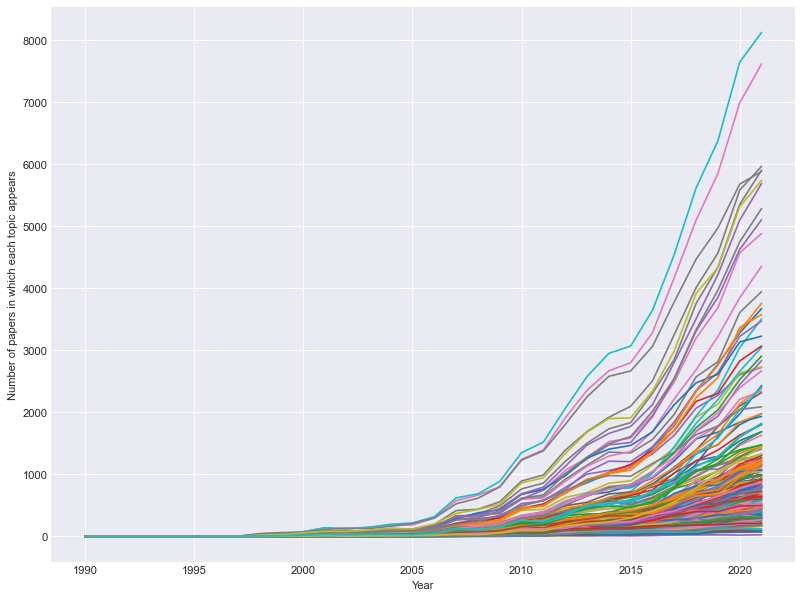

In [201]:
plt.style.use('seaborn-darkgrid')
k = len(set(y_pred))
plt.figure(figsize=(12, 9), dpi=80)
for i in range(k):
    plt.plot(x_plotting, y_plotting[i], label=i)
#plt.legend()
plt.xlabel("Year")
plt.ylabel("Number of papers in which each topic appears")
plt.savefig("../Graphs/topicHits.png")

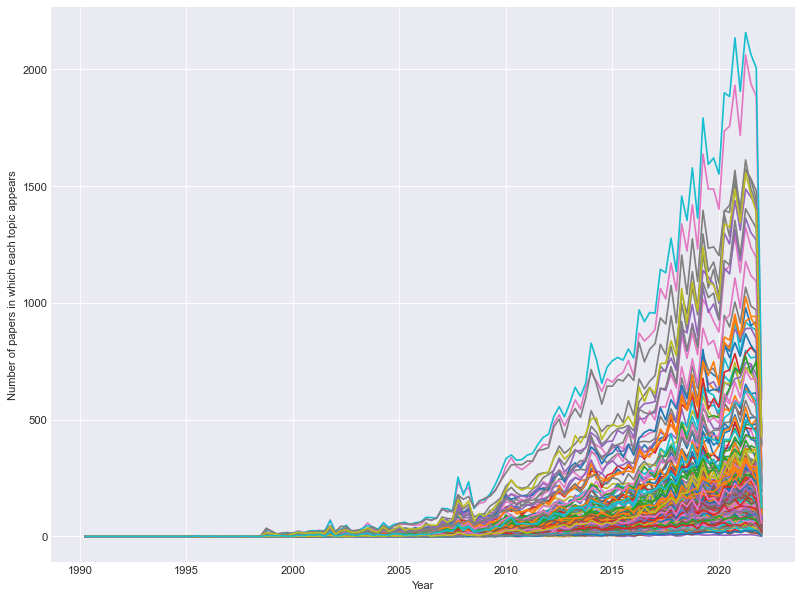

In [202]:
k = len(set(y_pred))
plt.figure(figsize=(12, 9), dpi=80)
for i in range(len(y_plotting_quarter)):
    plt.plot(np.divide(x_plotting_quarter, 4), y_plotting_quarter[i], label=i)
#plt.legend()
plt.xlabel("Year")
plt.ylabel("Number of papers in which each topic appears")
plt.savefig("../Graphs/topicHitsQuarter.png")

In [203]:
# Find how many abstracts there are per year
abstracts_per_year = {}
for index, row in df_combined.iterrows():
    if(row['year'] in abstracts_per_year.keys()):
        abstracts_per_year[row['year']] += 1
    else:
        abstracts_per_year[row['year']] = 1

# Find how many abstracts there are per quarter
abstracts_per_quarter = {}
for index, row in df_combined.iterrows():
    if(row['quarter'] in abstracts_per_quarter.keys()):
        abstracts_per_quarter[row['quarter']] += 1
    else:
        abstracts_per_quarter[row['quarter']] = 1

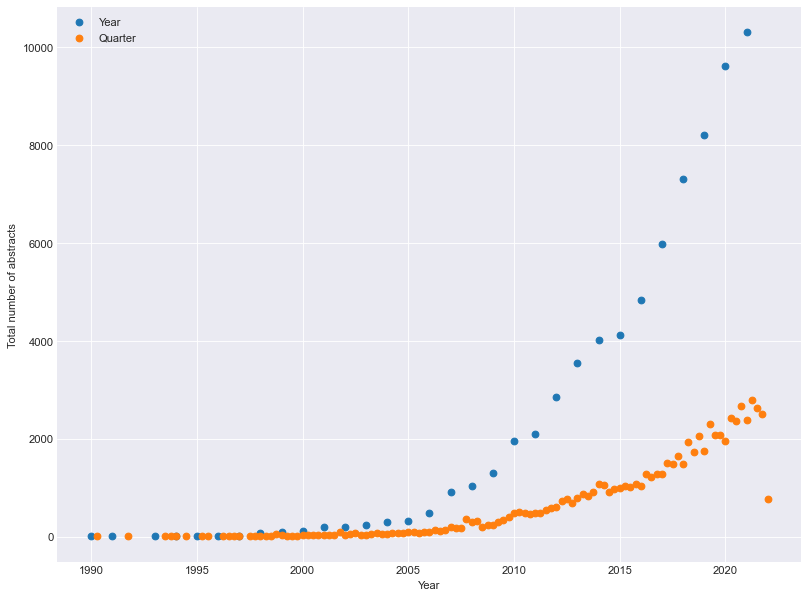

In [204]:
plt.figure(figsize=(12, 9), dpi=80)
plt.scatter(list(abstracts_per_year.keys()), list(abstracts_per_year.values()), label='Year')
x_abstracts_per_quarter = np.array([int(q) for q in abstracts_per_quarter.keys()])
x_abstracts_per_quarter = np.divide(x_abstracts_per_quarter, 4)
plt.scatter(x_abstracts_per_quarter, list(abstracts_per_quarter.values()), label='Quarter')
plt.xlabel('Year')
plt.ylabel('Total number of abstracts')
plt.legend()
plt.savefig('../Graphs/Final/abstractsPerYear')

In [205]:
#Normalization
hits_normalized_year = {}
for year in hits_per_year.keys():
    total = abstracts_per_year[year]
    hits_normalized_year[int(year)] = {}
    for key in hits_per_year[year].keys():
        hits_normalized_year[int(year)][key] = hits_per_year[year][key]/total

hits_normalized = {}
for quarter in hits_per_quarter.keys():
    total = abstracts_per_quarter[quarter]
    hits_normalized[int(quarter)] = {}
    for key in hits_per_quarter[quarter].keys():
        hits_normalized[int(quarter)][key] = hits_per_quarter[quarter][key]/total

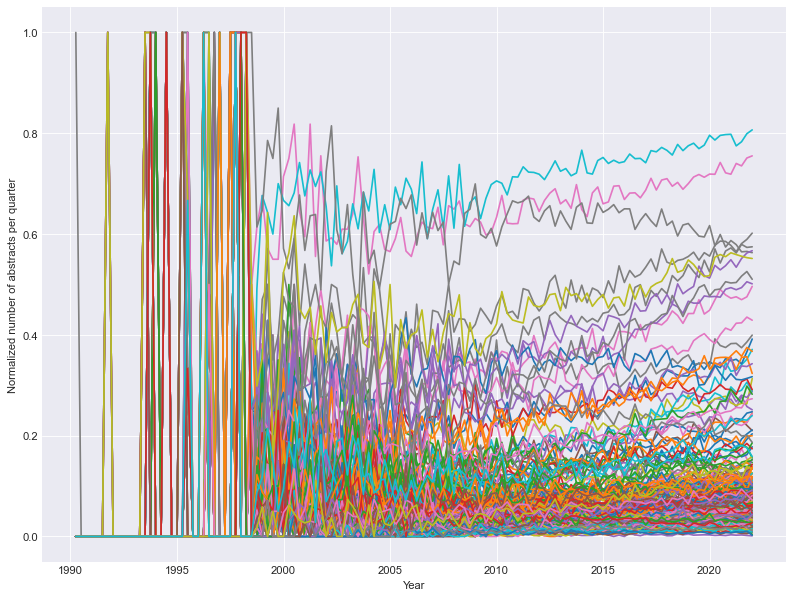

In [206]:
x_p, y_p = plottingParams(hits_normalized)
plt.figure(figsize=(12, 9), dpi=80)
for i in range(k):
    plt.plot(np.divide(x_p,4), y_p[i], label=i)
plt.ylabel('Normalized number of abstracts per quarter')
plt.xlabel('Year')
plt.savefig('../Graphs/Final/hitsPerYear.png')

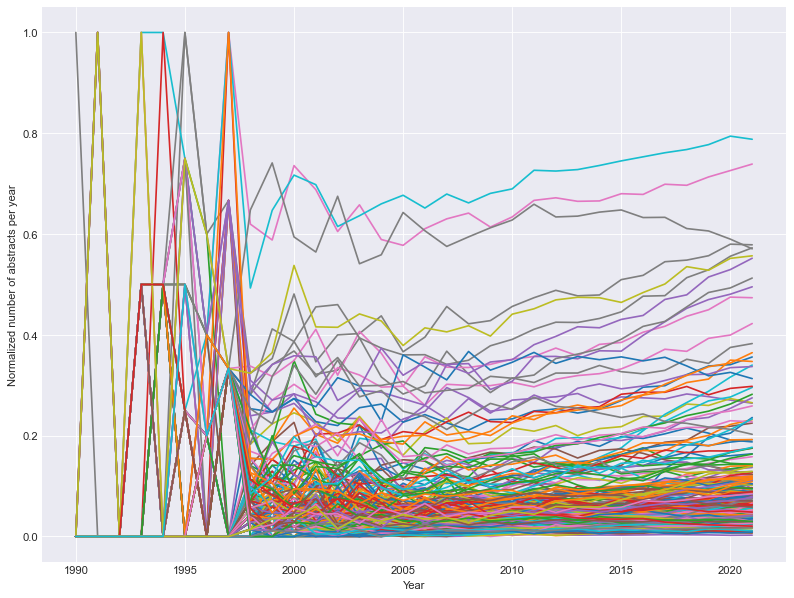

In [207]:
x_p_year, y_p_year = plottingParams(hits_normalized_year)
plt.figure(figsize=(12, 9), dpi=80)
for i in range(k):
    plt.plot(x_p_year, y_p_year[i], label=i)
plt.ylabel('Normalized number of abstracts per year')
plt.xlabel('Year')
plt.savefig('../Graphs/Final/hitsPerYearYear.png')

Cut off data before 2005 and which appear fewer than 8 times per year

In [208]:
def cutOff(hits_per_year, y):
    hits_new = {}
    for year in hits_per_year.keys():
        if(y):
            if(year >= 2005):
                hits_new[year] = {}
                for topic in hits_per_year[year]:
                    if hits_per_year[year][topic] > 8:
                        hits_new[year][topic] = hits_per_year[year][topic]
        else:
            if(year >= 8020):
                hits_new[year] = {}
                for topic in hits_per_year[year]:
                    if hits_per_year[year][topic] > 2:
                        hits_new[year][topic] = hits_per_year[year][topic]

    return hits_new

In [209]:
def findTotalTopicsPerYear(hits_per_year):
    topics_per_year = {}
    for year in hits_per_year.keys():
        topics_per_year[year] = sum(hits_per_year[year].values())
    return topics_per_year

In [210]:
def normalize(hits_per_year, abstracts_per_year):
    hits_normalized = {}
    for year in hits_per_year.keys():
        total = abstracts_per_year[year]
        hits_normalized[int(year)] = {}
        for key in hits_per_year[year].keys():
            hits_normalized[int(year)][key] = hits_per_year[year][key]/total
    return hits_normalized

In [211]:
hits_per_quarter2 = cutOff(hits_per_quarter, False)
hits_normalized = normalize(hits_per_quarter2, abstracts_per_quarter)

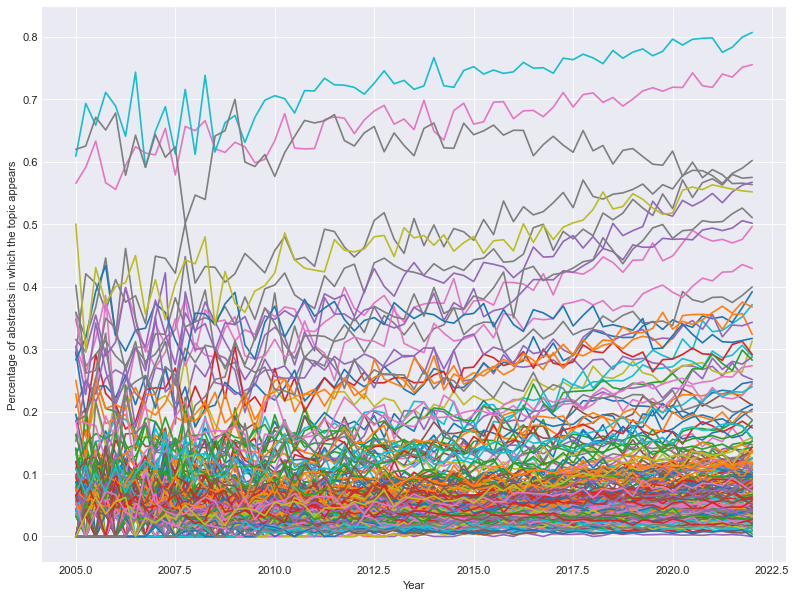

In [215]:
plt.style.use('seaborn-darkgrid')
x_p, y_p = plottingParams(hits_normalized)
plt.figure(figsize=(12, 9), dpi=80)
for i in range(k):
    plt.plot(np.divide(x_p, 4), y_p[i], label=i)
plt.ylabel('Percentage of abstracts in which the topic appears')
plt.xlabel('Year')
plt.savefig('../Graphs/Final/hitsNormalizedCut.png')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Baseline TSA on subject codes

In [ ]:
#ARIMA function
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.metrics import mean_squared_error
def arima_func(series):
    #Forcasting
    X = series
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    predictions = output
    # evaluate forecasts
    rmse = sqrt(mean_squared_error(test, predictions))
    
    return predictions

Modelling subjects

In [218]:
#Making time sequence for subjects
def makeTimeSeq(year_per_subject):
    time_seq = {}
    year_min = int(list(subject_per_year.keys())[-1])
    year_max = int(list(subject_per_year.keys())[0])
    for subj in year_per_subject.keys():
        arr = np.zeros(year_max-year_min+1)
        for year in year_per_subject[subj].keys():
            arr[year-year_min] = year_per_subject[subj][year]
        time_seq[subj] = arr
    return time_seq

In [228]:
df_combined = df_combined.rename(columns={'sub_category':'subfield'})

In [225]:
# Topic hits per year
# In this and that year I have this many IT, this many LG ...
def yearHits():
    hits_per_year = {}
    for index, row in df_combined.iterrows():
        if(row['quarter'] in hits_per_year.keys()):
            if(row['subfield'] in hits_per_year[row['quarter']].keys()):
                hits_per_year[row['quarter']][row['subfield']] += 1
            else:
                hits_per_year[row['quarter']][row['subfield']] = 1
        else:
            hits_per_year[row['quarter']] = {row['subfield'] : 1}
    for key in hits_per_year.keys():
        hits_per_year[key] = {k: v for k, v in sorted(dict(hits_per_year[key]).items(), key=lambda item: item[1], reverse=True)}

    hits_normalized = {}
    for year in hits_per_year.keys():
        total = 0
        hits_normalized[int(year)] = {}
        for key in hits_per_year[year].keys():
            total += hits_per_year[year][key]
        for key in hits_per_year[year].keys():
            hits_normalized[int(year)][key] = hits_per_year[year][key]/total
    
    hits_per_year = {k: v for k, v in sorted(dict(hits_per_year).items(), key=lambda item: item[0], reverse=True)}
    hits_normalized = {k: v for k, v in sorted(dict(hits_normalized).items(), key=lambda item: item[0], reverse=True)}

    return hits_per_year, hits_normalized

In [229]:
subject_per_year, subject_per_year_norm = yearHits()

In [233]:
# Convert dictionary
def year_to_subject(subject_per_year):
    year_per_subject = {}
    for year in subject_per_year.keys():
        d = subject_per_year[year]
        for subj in d.keys():
            if(subj in year_per_subject.keys()):
                year_per_subject[subj][year] = d[subj]
            else:
                year_per_subject[subj] = {year : d[subj]}
    return year_per_subject

In [234]:
year_per_subject_norm = year_to_subject(subject_per_year_norm)
time_seq = makeTimeSeq(year_per_subject_norm)

In [237]:
# Shorten time_seq to post 2005
def shortenTimeSeq(time_seq, y_p):
    ts2 = {}
    startingIndex = len(time_seq['AI'])-len(y_p[0])
    for subj in time_seq.keys():
        ts2[subj] = time_seq[subj][startingIndex:]
    return ts2

In [238]:
time_seq = shortenTimeSeq(time_seq, y_p)

In [231]:
def findSubjectTopicHits(topic, f):
    hits_per_field = {}
    for index, row in df_combined.iterrows():
        if(row[f] in hits_per_field.keys()):
            hits_per_field[row[f]] = Counter(hits_per_field[row[f]]) + Counter(row[topic])
        else:
            hits_per_field[row[f]] = Counter(row[topic])
    for key in hits_per_field.keys():
        hits_per_field[key] = {k: v for k, v in sorted(dict(hits_per_field[key]).items(), key=lambda item: item[1], reverse=True)}

    hits_normalized_field = {}
    for field in hits_per_field.keys():
        total = 0
        hits_normalized_field[field] = {}
        for key in hits_per_field[field].keys():
            total += hits_per_field[field][key]
        for key in hits_per_field[field].keys():
            hits_normalized_field[field][key] = hits_per_field[field][key]/total

    return hits_per_field, hits_normalized_field


In [232]:
subject_no, subject_topic_hits = findSubjectTopicHits('topic_hits', 'subfield')
topics_no, subject_topics = findSubjectTopicHits('topics', 'subfield')

Determining how good the topics are

In [247]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
def NBClassifier(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    mnb = MultinomialNB()
    mnb.fit(X_train, y_train)
    y_pred = mnb.predict(X_test)
    y_pred_classes = mnb.predict_proba(X_test)
    return y_pred, y_pred_classes